In [1]:
import layoutparser as lp
import cv2

In [2]:
image = cv2.imread("../data/1/0.jpg")
image = image[..., ::-1]

In [3]:
model = lp.AutoLayoutModel("lp://detectron2/PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x",
    #extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
    label_map={0: "Text", 1: "Figure"})

config.yaml?dl=1: 8.19kB [00:01, 5.11kB/s]
model_final.pth?dl=1: 856MB [00:45, 18.7MB/s]                           


In [4]:
layout = model.detect(image)
print(layout)

/usr/local/anaconda3/envs/cs492i/lib/python3.8/site-packages/detectron2/structures/image_list.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/anaconda3/envs/cs492i/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Layout(_blocks=[TextBlock(block=Rectangle(x_1=632.0882568359375, y_1=832.9512939453125, x_2=2014.2027587890625, y_2=1015.2110595703125), text=None, id=None, type=Figure, parent=None, next=None, score=0.9855484366416931), TextBlock(block=Rectangle(x_1=560.1564331054688, y_1=389.6376953125, x_2=2123.72509765625, y_2=767.2998046875), text=None, id=None, type=Figure, parent=None, next=None, score=0.8114268779754639), TextBlock(block=Rectangle(x_1=547.4832763671875, y_1=1087.3453369140625, x_2=2133.83251953125, y_2=1136.8521728515625), text=None, id=None, type=Figure, parent=None, next=None, score=0.7894883155822754), TextBlock(block=Rectangle(x_1=584.1928100585938, y_1=1085.2772216796875, x_2=2113.938720703125, y_2=1137.6666259765625), text=None, id=None, type=Text, parent=None, next=None, score=0.7111008763313293), TextBlock(block=Rectangle(x_1=672.8119506835938, y_1=897.2207641601562, x_2=1967.1593017578125, y_2=993.1074829101562), text=None, id=None, type=Figure, parent=None, next=None,

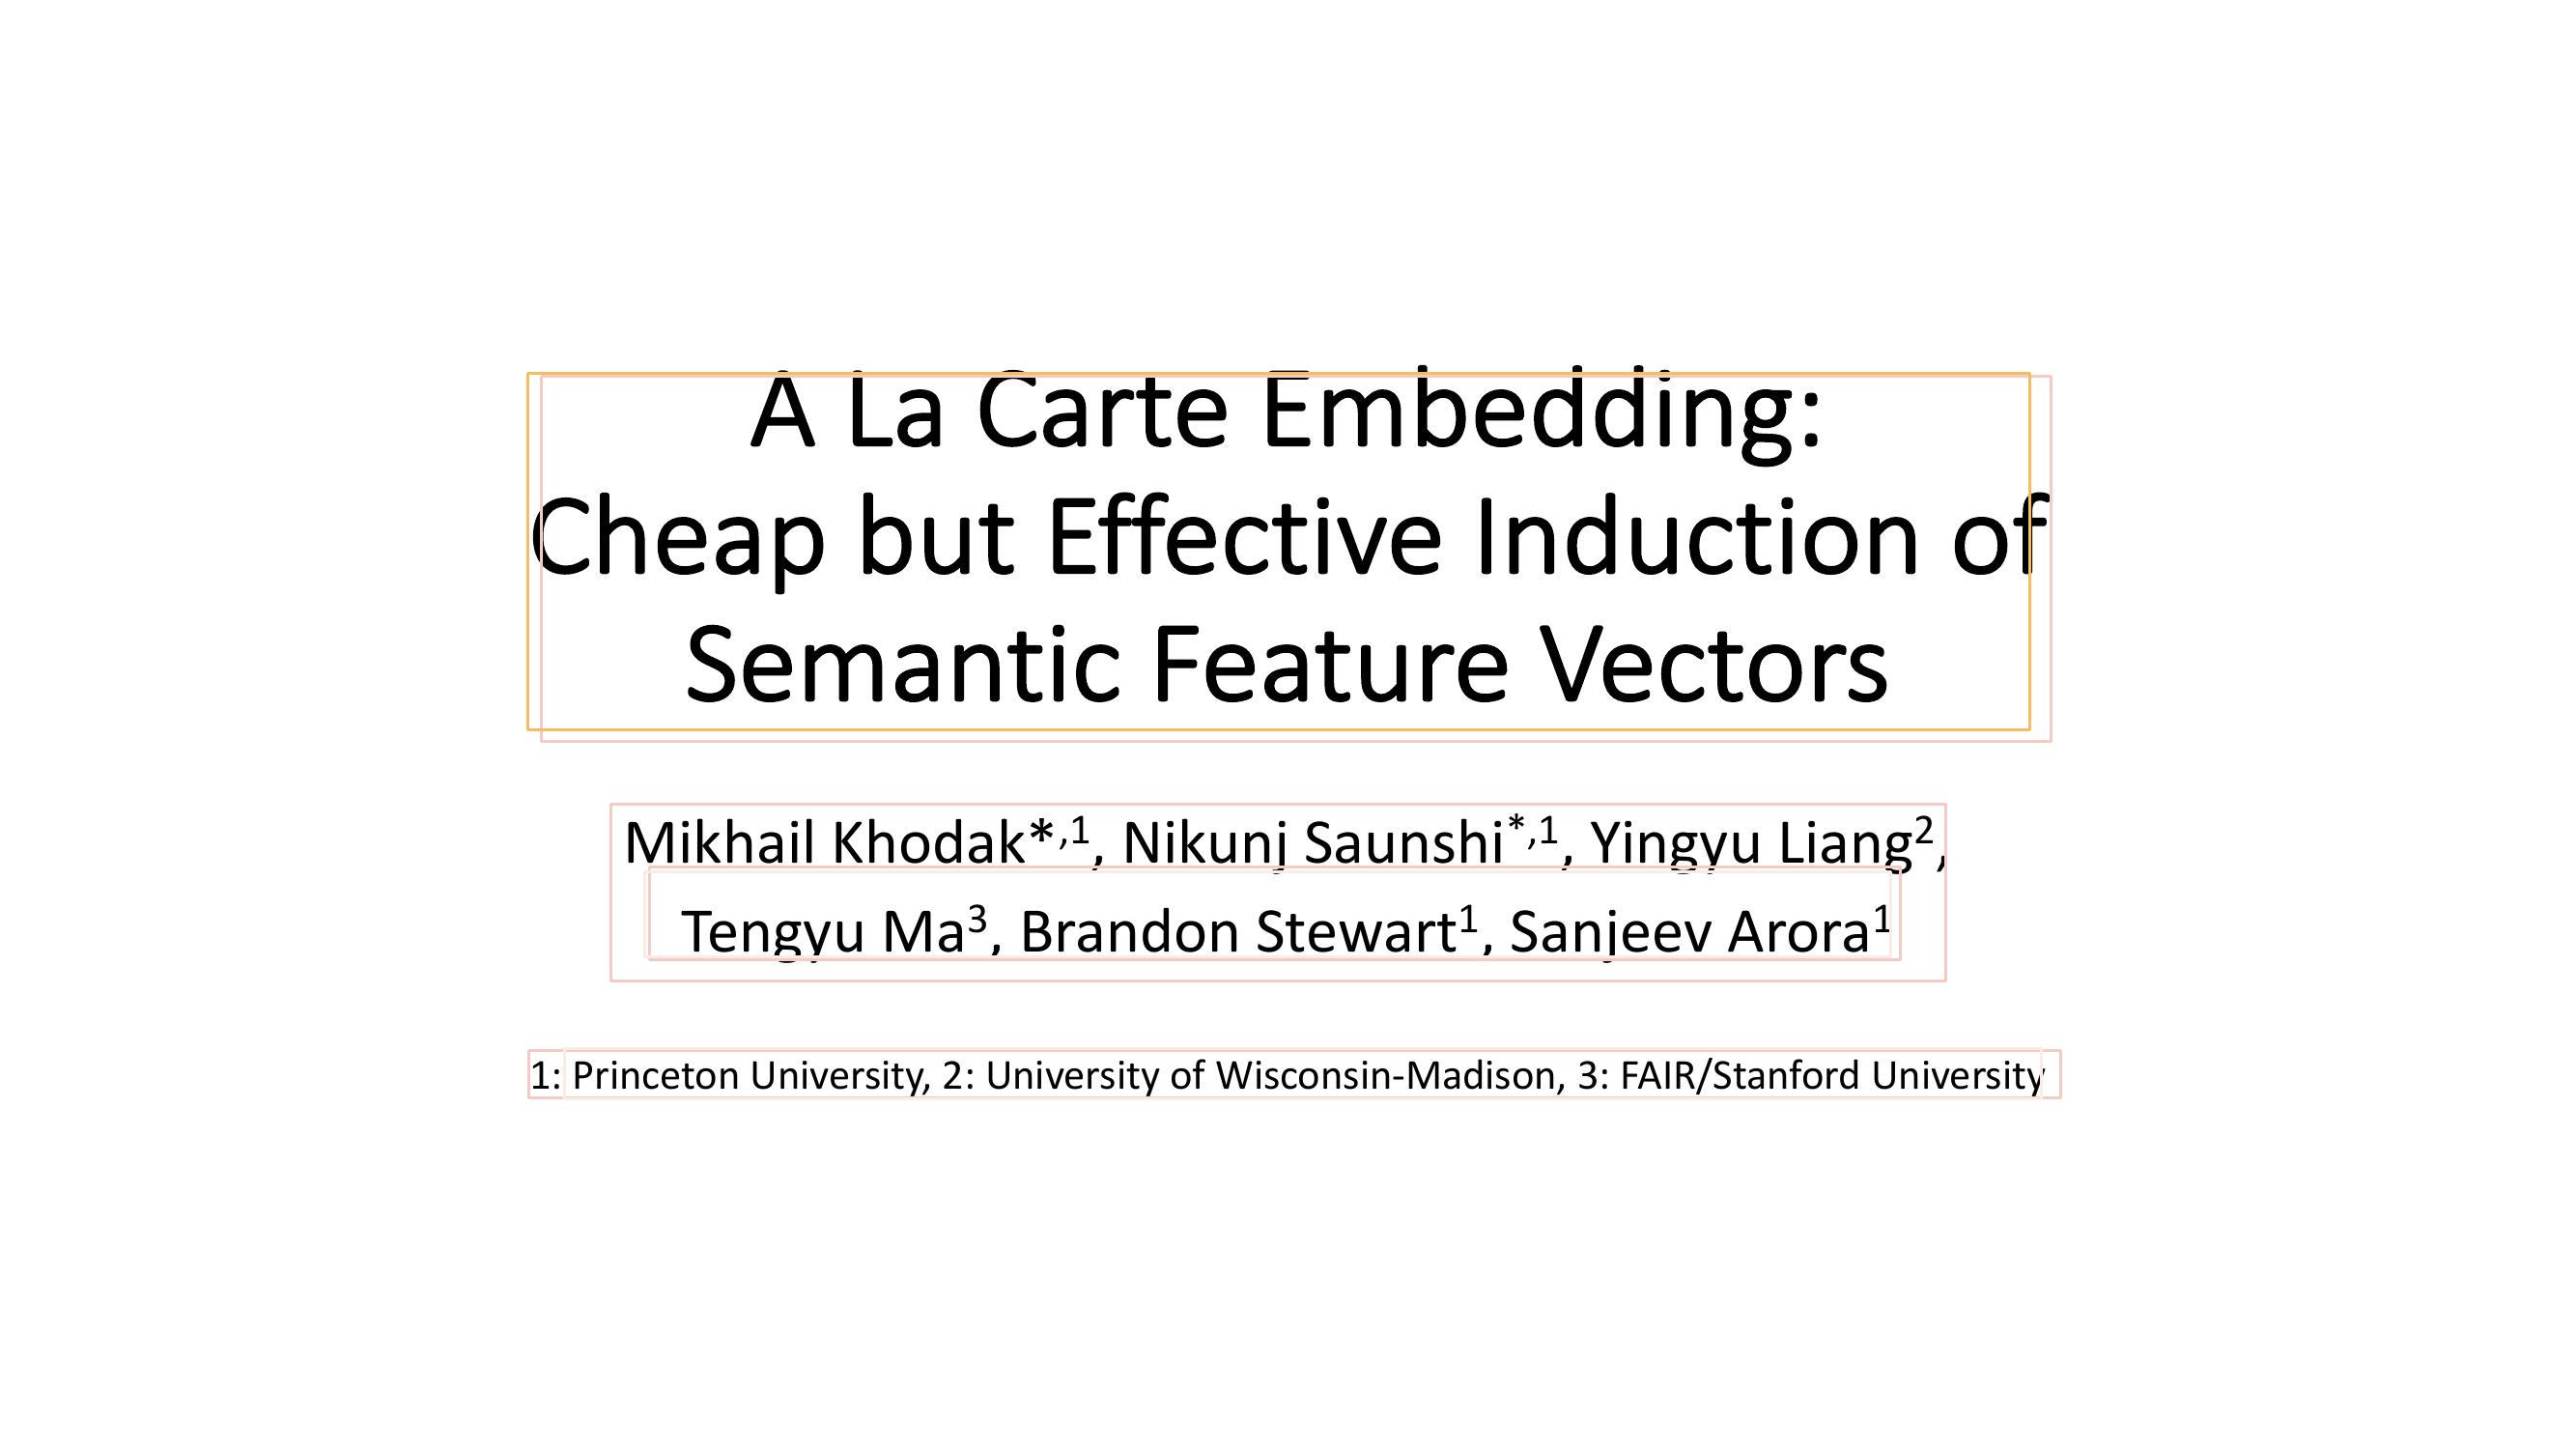

In [5]:
lp.draw_box(image, layout, box_width=3)

In [6]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [7]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [8]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])
print(text_blocks)

Layout(_blocks=[TextBlock(block=Rectangle(x_1=584.1928100585938, y_1=1085.2772216796875, x_2=2113.938720703125, y_2=1137.6666259765625), text=None, id=0, type=Text, parent=None, next=None, score=0.7111008763313293)], page_data={})


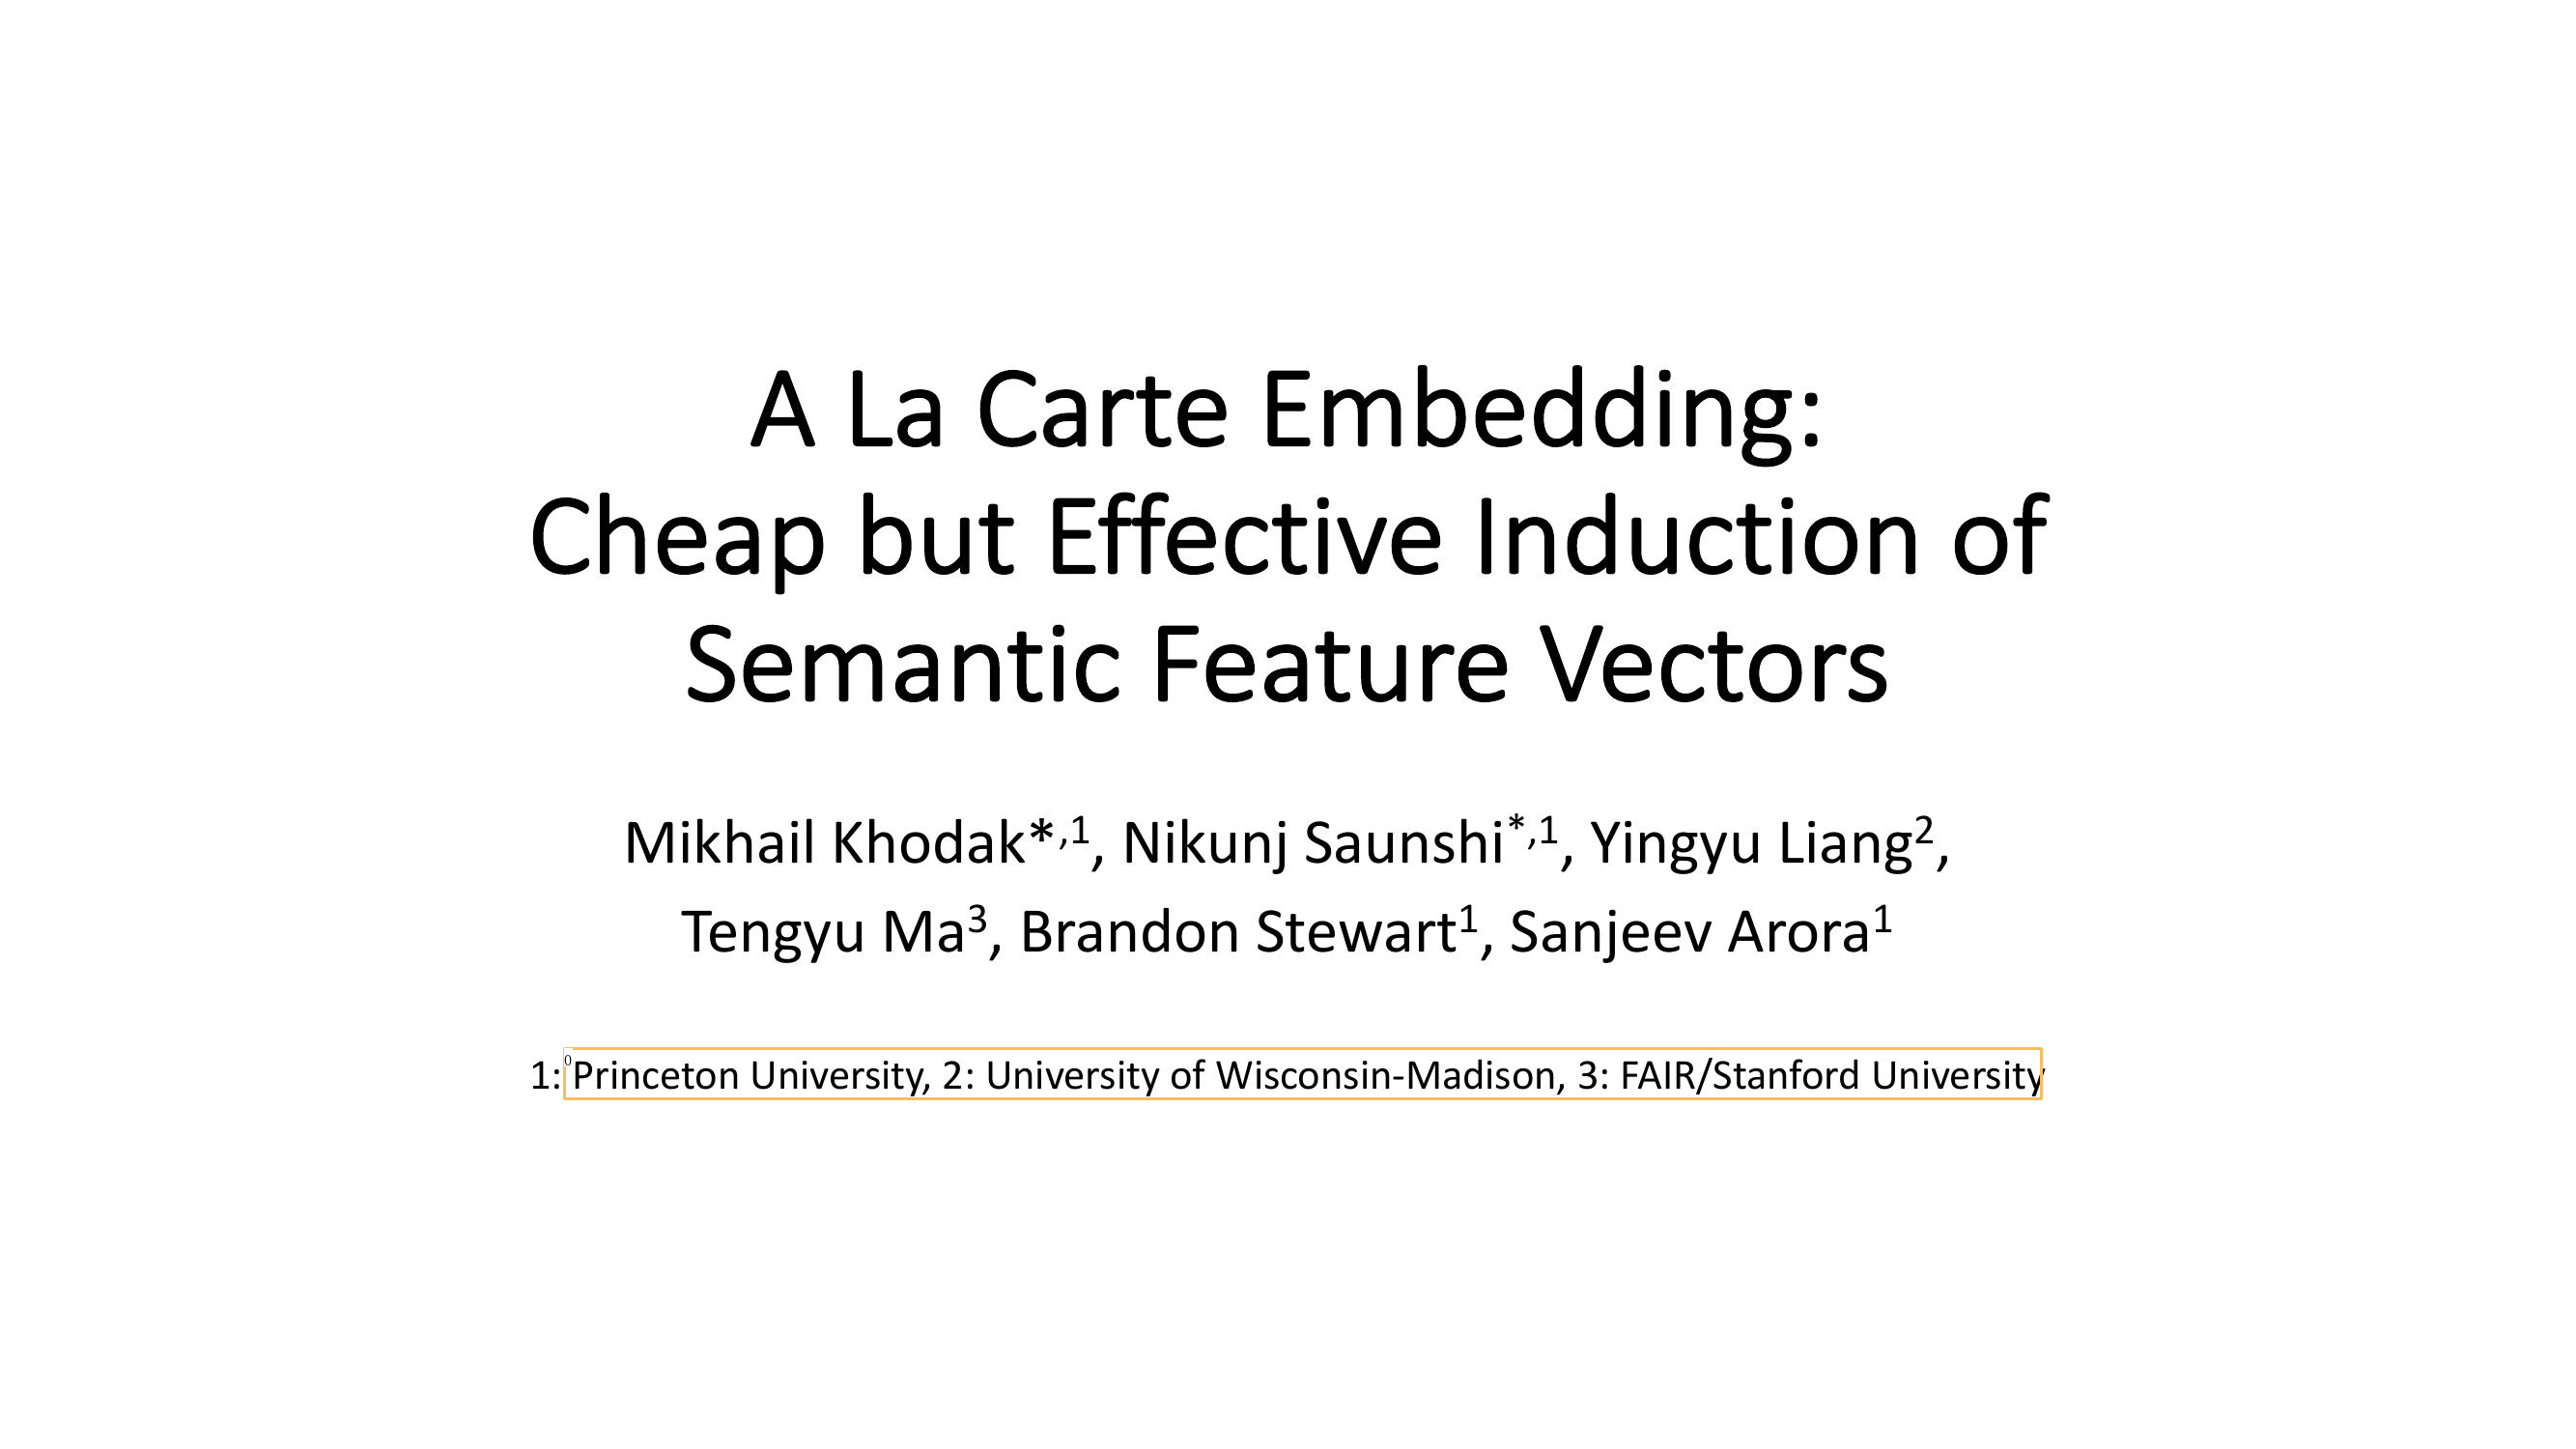

In [9]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [55]:
root = '../'

import os
from skimage import io, transform
import numpy as np
from pathlib import Path
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import mask_rcnn
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter

In [179]:
# Basic settings
from easydict import EasyDict as edict

cfg = []

torch.manual_seed(470)
torch.cuda.manual_seed(470)

args = edict()
args.batch_size = 1
args.lr = 1e-4
args.momentum = 0.9
args.weight_decay = 5e-4
args.epoch = 10
args.tensorboard = False
args.gpu = True
args.train_portion = 0.7

device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

# Create directory name.
result_dir = Path(root) / 'results'
result_dir.mkdir(parents=True, exist_ok=True)

In [180]:
if args.tensorboard:
    %load_ext tensorboard
    %tensorboard --logdir "{str(result_dir)}" --samples_per_plugin images=100

In [190]:
def draw_image(image, bbs):
    if (torch.is_tensor(image)):
        image = np.array(image.tolist()).transpose((1, 2, 0))
    if (torch.is_tensor(bbs)):
        bbs = np.array(bbs.tolist())

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for bb in bbs:
        rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

class FitVidDataset(Dataset):
    """ FitVid Dataset"""
    
    def __init__(self, img_data, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.img_data = img_data
        self.img_filenames = list(self.img_data.keys())
    
    def __len__(self):
        return len(self.img_filenames)

    def show_image(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        filename = self.img_filenames[idx]
        img_dir = os.path.join(self.root_dir, filename)
        
        image = io.imread(img_dir)
        draw_image(image, self.img_data[filename]['bbs'])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        filename = self.img_filenames[idx]
        img_dir = os.path.join(self.root_dir, filename)
        image = io.imread(img_dir)

        bbs = self.img_data[filename]['bbs']

        sample = {
            'image' : image,
            'labels' : bbs,
        }
        
        if self.transform:
            sample = self.transform(sample)
        return sample

In [191]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        labels = labels * np.array([new_w / w, new_h / h, new_w / w, new_h / h, 1]).T
        return {'image': img, 'labels': labels}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]
        labels = labels - np.array([left, top, 0, 0, 0]).T

        return {'image': image, 'labels': labels}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}

In [198]:
BB_TYPES = [
    'title',
    'header',
    'text box',
    'footer',
    'picture',
    'instructor',
    'diagram',
    'table',
    'figure',
    'handwriting',
    'chart',
    'schematic diagram',
]

def process_dataset(all_dataset, root_dir):
    img_data = {}
    for entrance in all_dataset.iloc:
        filename = entrance['filename']
        img_dir = os.path.join(root_dir, filename)
        if (os.path.exists(img_dir) is False):
            continue
        if (filename not in img_data):
            img_data[filename] = {
                'bbs': [],
                'img_w' : entrance['Image Width'],
                'img_h' : entrance['Image Height'],
            }
        
        bb_type = BB_TYPES.index(entrance['Type'])
        if (bb_type < 0 or bb_type >= len(BB_TYPES)):
            bb_type = len(BB_TYPES)

        bb = np.array([
            entrance['X'],
            entrance['Y'],
            entrance['BB Width'],
            entrance['BB Height'],
            bb_type
        ]).T
        img_data[filename]['bbs'].append(bb)
    return img_data

def slice_dict(dictionary, l, r):
    keys = list(dictionary.keys())
    keys = keys[l:r]
    ret_dictionary = {}
    for key in keys:
        ret_dictionary[key] = dictionary[key]
    return ret_dictionary

In [208]:
### path to images folder
root_dir = '/Users/fesiib/Desktop/KIXLab/dev/lecture-design-dataset/dataset/images/'
### path to csv file
csv_file = '/Users/fesiib/Desktop/KIXLab/dev/lecture-design-dataset/dataset/ver123_schema.csv'

dataset = pd.read_csv(csv_file)
img_data = process_dataset(dataset, root_dir)

division = int(args.train_portion * len(img_data))

train_dataset = FitVidDataset(
    img_data=slice_dict(img_data, 0, division),
    root_dir=root_dir,
    transform = transforms.Compose([
        Rescale(256),
        RandomCrop(128),
        ToTensor(),
    ])
)
test_dataset = FitVidDataset(
    img_data=slice_dict(img_data, division, len(img_data)),
    root_dir=root_dir,
    transform = transforms.Compose([
        Rescale(256),
        RandomCrop(128),
        ToTensor(),
    ])
)

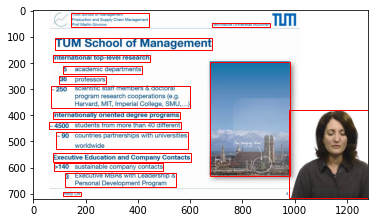

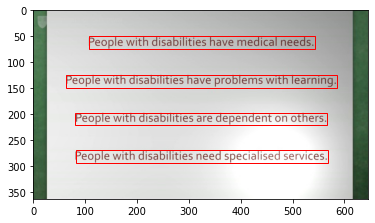

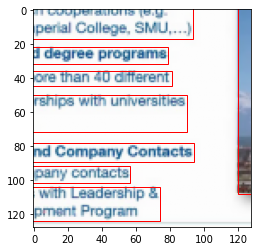

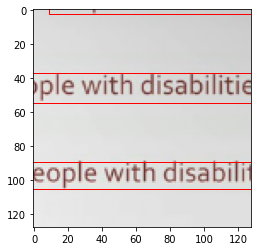

In [207]:
train_dataset.show_image(1)
test_dataset.show_image(0)
sample = train_dataset[1]
draw_image(sample['image'], sample['labels'])

sample = test_dataset[0]
draw_image(sample['image'], sample['labels'])

In [209]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)

In [ ]:
class Model1(mask_rcnn):
    def __init__(self):
        super(Model1, self).__init__(make_layers(cfg['vgg16']))

        self.numclass = 21

        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout2d()

        # fc layers in vgg are all converted into conv layers.
        #################################
        ## P1(a). Write your code here ##
        #################################
        self.fc6_conv = nn.Conv2d(512, 4096, 7)
        self.fc7_conv = nn.Conv2d(4096, 4096, 1)

        # Prediction layer with 1x1 convolution layer.
        #################################
        ## P1(b). Write your code here ##
        #################################
        self.classify_conv = nn.Conv2d(4096, self.numclass, 1)

        # Learnable upsampling layers in FCN model.
        #################################
        ## P1(c). Write your code here ##
        #################################
        self.upsample_conv = nn.ConvTranspose2d(self.numclass, self.numclass, 64, 32, bias=False)
        # initialize deconv layer with bilinear upsampling.
        self._initialize_weights()

    def load_pretrained(self, pretrained_model):
        self.features = pretrained_model.features
        fc6 = pretrained_model.classifier[0]
        fc7 = pretrained_model.classifier[3]

        #################################
        ## P1(d). Write your code here ##
        #################################
        fc6_weight = fc6.weight.clone().view_as(self.fc6_conv.weight)
        fc6_bias = fc6.bias.clone().view_as(self.fc6_conv.bias)
        fc7_weight = fc7.weight.clone().view_as(self.fc7_conv.weight)
        fc7_bias = fc7.bias.clone().view_as(self.fc7_conv.bias)

        self.fc6_conv.weight.data.copy_(fc6_weight)
        self.fc6_conv.bias.data.copy_(fc6_bias)
        self.fc7_conv.weight.data.copy_(fc7_weight)
        self.fc7_conv.bias.data.copy_(fc7_bias)

    def vgg_layer_forward(self, x, indices):
        output = x
        start_idx, end_idx = indices
        for idx in range(start_idx, end_idx):
            output = self.features[idx](output)
        return output

    def vgg_forward(self, x):
        out = {}
        layer_indices = [0, 5, 10, 17, 24, 31]
        for layer_num in range(len(layer_indices)-1):
            x = self.vgg_layer_forward(x, layer_indices[layer_num:layer_num+2])
            out[f'pool{layer_num+1}'] = x
        return out

    def forward(self, x):
        # Padding for aligning to the input size
        padded_x = F.pad(x, [100, 100, 100, 100], "constant", 0)
        vgg_features = self.vgg_forward(padded_x)
        vgg_pool5 = vgg_features['pool5'].detach()
        vgg_pool4 = vgg_features['pool4'].detach()
        vgg_pool3 = vgg_features['pool3'].detach()

        #################################
        ## P1(e). Write your code here ##
        #################################

        out = self.dropout(self.relu(self.fc6_conv(vgg_pool5)))
        out = self.dropout(self.relu(self.fc7_conv(out)))
        out = self.classify_conv(out)
        out = self.upsample_conv(out)

        H, W = x.shape[-2], x.shape[-1]
        out = transforms.functional.crop(out, 9, 9, H, W)
        return out

    # initialize transdeconv layer with bilinear upsampling.
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)
